<a href="https://colab.research.google.com/github/ITU-Business-Analytics-Team/Business_Analytics_for_Professionals/blob/main/Part%20I%20%3A%20Methods%20%26%20Technologies%20for%20Business%20Analytics/Chapter%207%3A%20Text%20Analytics/7_4_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Text Analytics**
## Text Classification

###**Spam Classification Example**

**4.1. Understanding the text classification task**

In this notebook, a spam classification example is explained step by step. Before starting to dataset preparation, Python libraries need to be imported to carry out given classification task.

In [ ]:
# if not previously installed, install nltk for text preprocessing
!pip install nltk
# if not previously installed, install lime for understanding the individual impact of each word
!pip install lime
# if not previously installed, install wordcloud for creating world clouds of each class (spam and ham) 
!pip install wordcloud

In [ ]:
# to process text
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
import re
import numpy as np
# to plot
import matplotlib.pyplot as plt
import seaborn as sns
# to prepare dataset
import pandas as pd
import nltk
from sklearn.model_selection import train_test_split
# for bag-of-words
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing, feature_selection,metrics
# for explainer
from lime import lime_text
# to obtain reproducible results
np.random.seed(2)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**4.2 Dataset Preparation**

To classify an SMS message as spam or ham, dataset should be labelled. First, the dataset is read and inspected by 'head' function of pandas to see columns and understanding data types.

In [ ]:
#dtf = pd.read_csv('./spam.csv', encoding='latin-1')  
#dtf.head()
# read the data  
url=   'https://docs.google.com/spreadsheets/d/119aFhwfkrwYcRIwkAYMUXcSmC5_AdIMY/edit?usp=sharing&ouid=108589602591644119588&rtpof=true&sd=true'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
dtf = pd.read_excel(path)

The columns 'Unnamed: 2', 'Unnamed: 3' and 'Unnamed: 4' do not have any impactful contribution for the classification task due including 'NaN'. They could be dropped without hurting the performance of the models. Also, to easier the understanding of column names, 'v1' could be changed to 'label' and 'v2' to 'message'.

In [ ]:
dtf.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis = 1, inplace = True)
dtf.rename(columns = {'v1': 'labels', 'v2': 'message'}, inplace = True)

Since machine learning models work with labels represented as number, 'spam' and 'label' are mapped to numbers.

In [ ]:
dtf['label'] = dtf['labels'].map({'ham': 0, 'spam': 1})
dtf.drop(['labels'], axis = 1, inplace = True)
print(dtf.sample(5))

                                                message  label
5086  Omg if its not one thing its another. My cat h...      0
2120  Argh my 3g is spotty, anyway the only thing I ...      0
2318                          On the way to office da..      0
2917                      Thanks chikku..:-) gud nyt:-*      0
1352  Let Ur Heart Be Ur Compass Ur Mind Ur Map Ur S...      0


Visuals could be helpful to understand the distribution of classes within the dataset. Also, word clouds leads to have intitution about which words are more attrituble to spam messages.

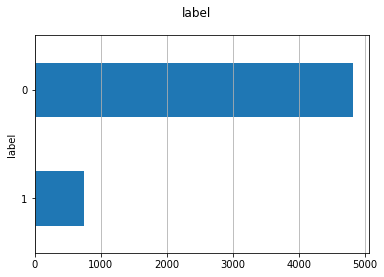

In [ ]:
fig, ax = plt.subplots()
fig.suptitle("label", fontsize=12)
dtf["label"].reset_index().groupby("label").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

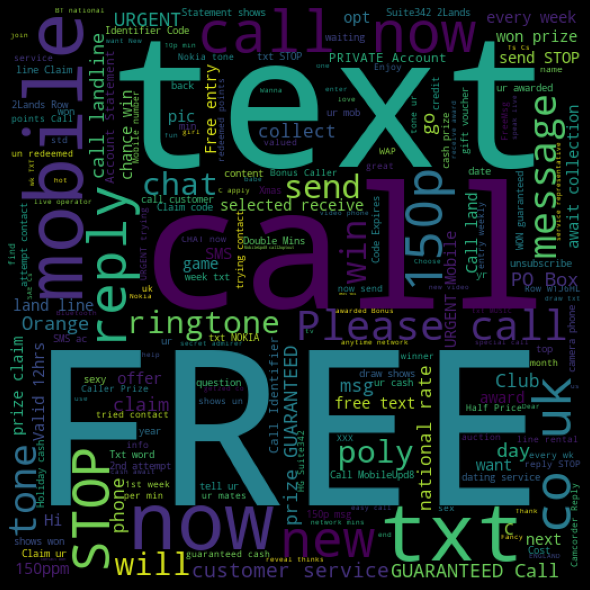

In [ ]:
from wordcloud import WordCloud
spam_words = ' '.join(list(dtf[dtf['label'] == 1]['message']))
spam_wc = WordCloud(width = 512,height = 512).generate(spam_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(spam_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()


Spam messages word cloud reveals that more 'free' offerings have higher probability to turns out being spam messages as aligned with heuristic.

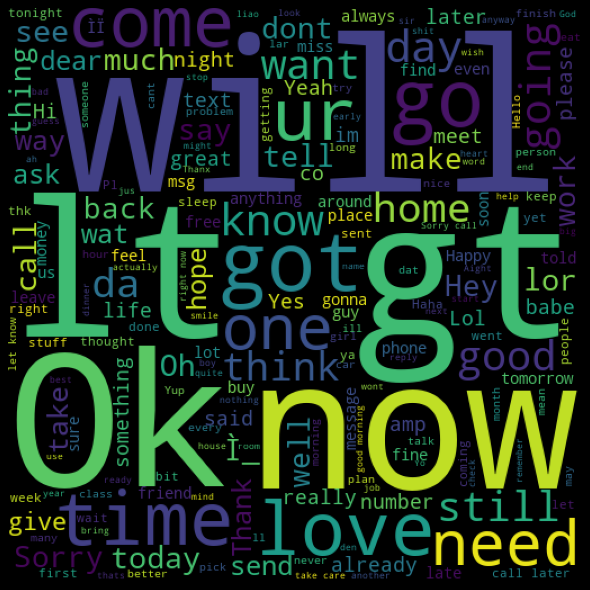

In [ ]:
ham_words = ' '.join(map(str,list(dtf[dtf['label'] == 0]['message'])))
ham_wc = WordCloud(width = 512,height = 512).generate(ham_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(ham_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

Compared to spam messages, ham messages do not include commercial context necessarily as can be seen above.

**4.3 Text preprocessing**

Second step is processing to text for prepare it to a machine learning model. To understand the individual effect of words on classes, it is needed to work on their most raw versions such as without -ing, -ed or excluding preprositions and stop words. Following function, first converts all letters to lower ones. Then process the each word regarding assigned preferences. In default, it removes stop words, apply stemming and lemmatisation. Finally, it returns preprocessed text.

In [ ]:
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    # clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    # Tokenize (convert from string to list)
    lst_text = text.split()
    # remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    # Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    # Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    # back to string from list
    text = " ".join(lst_text)
    return text



In [ ]:
# the messages are in English language, so nltk english stop words are
# are leveraged
lst_stopwords = nltk.corpus.stopwords.words("english")

dtf["message_clean"] = dtf["message"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=True, flg_lemm=True, 
          lst_stopwords=lst_stopwords))

dtf.dropna()
print(dtf.head())

                                             message  ...                                      message_clean
0  Go until jurong point, crazy.. Available only ...  ...  go jurong point crazi avail bugi n great world...
1                      Ok lar... Joking wif u oni...  ...                              ok lar joke wif u oni
2  Free entry in 2 a wkly comp to win FA Cup fina...  ...  free entri 2 wkli comp win fa cup final tkt 21...
3  U dun say so early hor... U c already then say...  ...                u dun say earli hor u c alreadi say
4  Nah I don't think he goes to usf, he lives aro...  ...          nah dont think goe usf live around though

[5 rows x 3 columns]


In [ ]:
"""Example message from the dataset to understand text processing"""

x="""I HAVE A DATE ON SUNDAY WITH WILL!!"""
utils_preprocess_text(x, flg_stemm=True, flg_lemm=True, 
          lst_stopwords=lst_stopwords)

'date sunday'

Now, the text is ready to produce descriptive features. As described in the book, there are several ways to do it. Count vectorizer and TF-IDF implementations are placed below. But before implementing them, the dataset is split into train and test since only train dataset should be used to train the model, so the descriptive features only be collected over this part of the entire corpus. 

In [ ]:
dtf_train, dtf_test = model_selection.train_test_split(dtf, test_size=0.3, random_state=42)
y_train = dtf_train["label"].values
y_test = dtf_test["label"].values

To select meaningful features, 0.99 p-limit is applied with Chi-square statistical feature selection method.

In [ ]:
# Count vecorizer (classic BoW)
# vectorizer = feature_extraction.text.CountVectorizer(max_features=10000, ngram_range=(1,3))

# Tf-Idf (advanced variant of BoW)
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,3))

corpus = dtf_train["message_clean"]
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

y = dtf_train["label"]
X_names = vectorizer.get_feature_names()
p_value_limit = 0.99
dtf_features = pd.DataFrame()
for cat in np.unique(y):
    chi2, p = feature_selection.chi2(X_train, y==cat)
    dtf_features = dtf_features.append(pd.DataFrame(
                   {"feature":X_names, "p-score":1-p, "label":cat}))
    dtf_features = dtf_features.sort_values(["label","p-score"], 
                    ascending=[True,False])
    dtf_features = dtf_features[dtf_features["p-score"]>p_value_limit]
X_names = dtf_features["feature"].unique().tolist()
    
vectorizer = feature_extraction.text.TfidfVectorizer(vocabulary=X_names)
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

Top features of each class can be seen below.

In [ ]:
for cat in np.unique(y):
    print("# {}:".format(cat))
    print("  . selected features:",
         len(dtf_features[dtf_features["label"]==cat]))
    print("  . top features:", ",".join(dtf_features[dtf_features["label"]==cat]["feature"].values[:10]))
    print(" ")

# 0:
  . selected features: 331
  . top features: claim,txt,free,prize,mobil,tone,servic,award,urgent,call
 
# 1:
  . selected features: 331
  . top features: claim,txt,free,prize,mobil,tone,servic,award,urgent,call
 


**4.4. Model Training**

After selecting features, they could be supplied to a machine learning classifier. There are several classifier algorithms and most of them are suitable and have considerably high performance with the text classification tasks such as in spam classification. Following function initialize selected model and produce prediction for classes. It utilizes given vectorizer and machine learning algorithm. At the end of validation, it gives accuracy, precision and recall metrics to compare performance of different classifiers.

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

def predict(X_train, y_train, y_test, classifier=MLPClassifier(alpha=1, max_iter=50), name="Neural Net"):
    print('---------------Prediction with '+name+ '---------------------------')
    
    # Pipeline
    model = pipeline.Pipeline([("vectorizer", vectorizer), ("classifier", classifier)])
    model["classifier"].fit(X_train, y_train)
    
    # Test
    X_test = dtf_test["message_clean"].values
    predicted = model.predict(X_test)
    predicted_prob = model.predict_proba(X_test)

    classes = np.unique(y_test)
    y_test_array = pd.get_dummies(y_test, drop_first=False).values

    # Accuracy, Precision, Recall
    accuracy = metrics.accuracy_score(y_test, predicted)
    auc = metrics.roc_auc_score(y_test, predicted)
    print("Accuracy:",  round(accuracy,2))
    print("Auc:", round(auc,2))
    print("Detail:")
    print(metrics.classification_report(y_test, predicted))

    # Plot confusion matrix
    cm = metrics.confusion_matrix(y_test, predicted)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, yticklabels=classes, title="Confusion matrix")
    plt.yticks(rotation=0)

    fig, ax = plt.subplots(nrows=1, ncols=2)

    # Plot roc
    for i in range(len(classes)):
        fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  predicted_prob[:,i])
        ax[0].plot(fpr, tpr, lw=3, label='{0} (area={1:0.2f})'.format(classes[i], metrics.auc(fpr, tpr)))
    ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
    ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
              xlabel='False Positive Rate', 
              ylabel="True Positive Rate (Recall)", 
              title="Receiver operating characteristic: \n" + name)
    ax[0].legend(loc="lower right")
    ax[0].grid(True)

    # Plot precision-recall curve
    for i in range(len(classes)):
        precision, recall, thresholds = metrics.precision_recall_curve(
                     y_test_array[:,i], predicted_prob[:,i])
        ax[1].plot(recall, precision, lw=3, label='{0} (area={1:0.2f})'.format(classes[i], metrics.auc(recall, precision)))
    
    ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
              ylabel="Precision", title="Precision-Recall curve:\n " + name)
    ax[1].legend(loc="best")
    ax[1].grid(True)
    plt.show()
    
    return predicted, predicted_prob, model

---------------Prediction with Nearest Neighbors---------------------------
Accuracy: 0.94
Auc: 0.83
Detail:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1453
           1       0.86      0.68      0.76       219

    accuracy                           0.94      1672
   macro avg       0.91      0.83      0.86      1672
weighted avg       0.94      0.94      0.94      1672



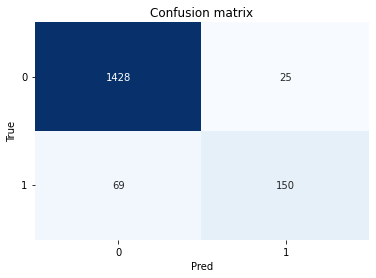

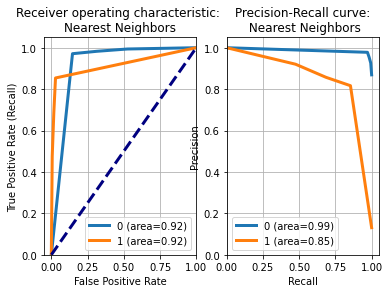

---------------Prediction with Decision Tree---------------------------
Accuracy: 0.95
Auc: 0.82
Detail:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1453
           1       0.99      0.65      0.78       219

    accuracy                           0.95      1672
   macro avg       0.97      0.82      0.88      1672
weighted avg       0.95      0.95      0.95      1672



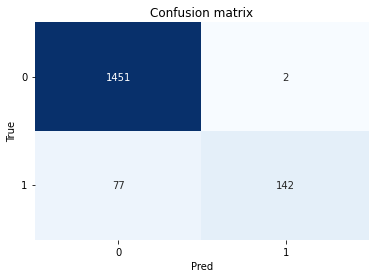

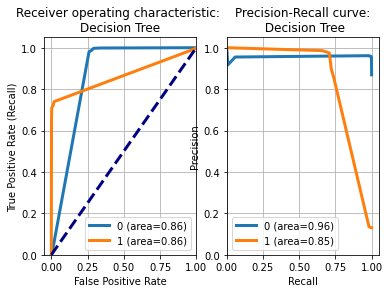

---------------Prediction with Random Forest---------------------------
Accuracy: 0.87
Auc: 0.51
Detail:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      1453
           1       1.00      0.02      0.04       219

    accuracy                           0.87      1672
   macro avg       0.94      0.51      0.48      1672
weighted avg       0.89      0.87      0.81      1672



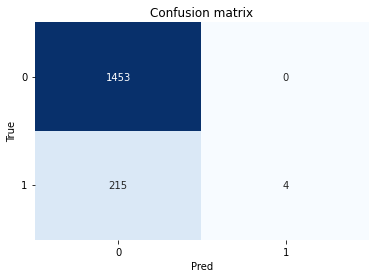

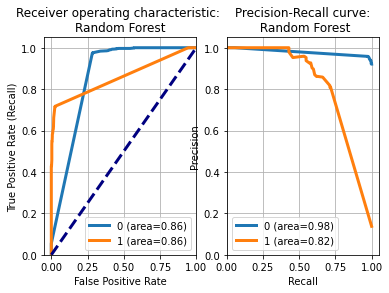

---------------Prediction with Neural Net---------------------------
Accuracy: 0.96
Auc: 0.85
Detail:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1453
           1       0.97      0.71      0.82       219

    accuracy                           0.96      1672
   macro avg       0.97      0.85      0.90      1672
weighted avg       0.96      0.96      0.96      1672



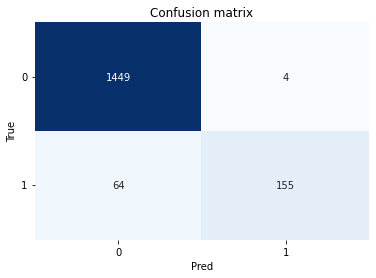

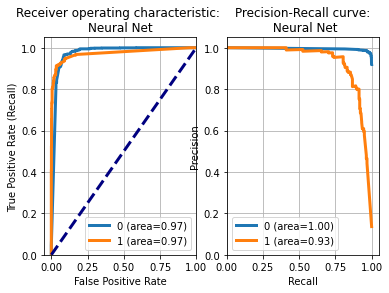

---------------Prediction with AdaBoost---------------------------
Accuracy: 0.97
Auc: 0.89
Detail:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1453
           1       0.96      0.78      0.86       219

    accuracy                           0.97      1672
   macro avg       0.96      0.89      0.92      1672
weighted avg       0.97      0.97      0.97      1672



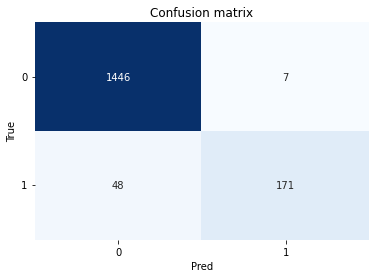

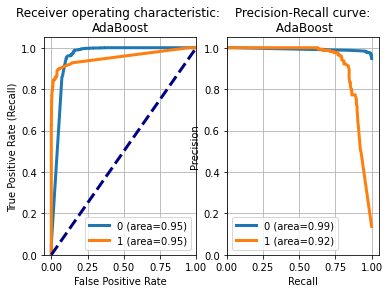

---------------Prediction with Naive Bayes---------------------------
Accuracy: 0.93
Auc: 0.72
Detail:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      1453
           1       1.00      0.43      0.61       219

    accuracy                           0.93      1672
   macro avg       0.96      0.72      0.78      1672
weighted avg       0.93      0.93      0.91      1672



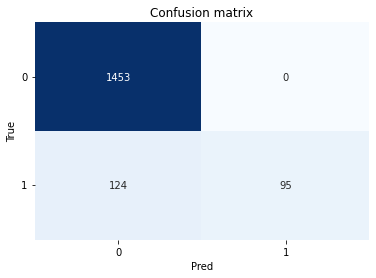

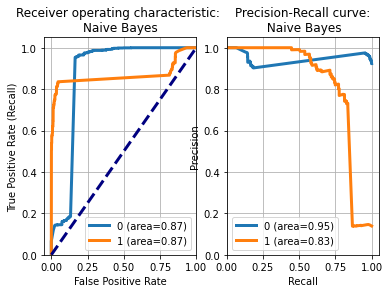

In [ ]:
df_classifiers = [
    KNeighborsClassifier(3),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    naive_bayes.MultinomialNB()]

names = ["Nearest Neighbors", 
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes"]


# train classifier
for name, classifier in zip(names, df_classifiers):
    predict(X_train, y_train, y_test, classifier, name)

The best performed model is the Adaboost algorithm with a 97% accuracy. Since algorithm performance depends on the randomized initial points, different accuracy values could be obtained in different settings. It is possible to check the trained model with individual sample and observe the effect of text processing and feature selection through 'Lime'.

---------------Prediction with Neural Net---------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Accuracy: 0.96
Auc: 0.85
Detail:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1453
           1       0.98      0.69      0.81       219

    accuracy                           0.96      1672
   macro avg       0.97      0.85      0.89      1672
weighted avg       0.96      0.96      0.96      1672



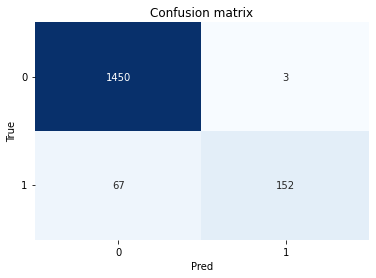

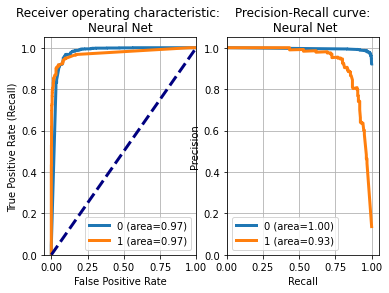

True: 0 --> Pred: 0 | Prob: 0.88


In [ ]:
predicted, predicted_prob, model = predict(X_train, y_train, y_test)
## select observation
i = 94
txt_instance = dtf_test["message"].iloc[i]
## check true value and predicted value
print("True:", y_test[i], "--> Pred:", predicted[i], "| Prob:", round(np.max(predicted_prob[i]),2))
## show explanation
explainer = lime_text.LimeTextExplainer(class_names=np.unique(y_train))
explained = explainer.explain_instance(txt_instance, model.predict_proba, num_features=10)
explained.show_in_notebook(text=txt_instance, predict_proba=False)